###  Dim Configuration
input x = 1 x n_samples -conv-> 1 x n_samples -Pow + Sum >  1 x n_samples = resut y

In [304]:
### Generate data
import numpy as np
def Convolution(X, k_conv, ConvW):
    """
    k_conv is and odd number
    :param X: 1 x k_conv, center is the current state
    :param k_conv: kernel size
    :param ConvW: 1 x k_conv

    :return: 1 x n_samples
    """
    y = np.zeros(1, dtype = np.complex128)
    for i in range(k_conv):
        y += ConvW[k_conv-i-1] * X[i]
    return y

def Polynomial(X, p ,PolyW, scaling_factor=1):
    """
    :param X: 1 x 1, complex number
    :param p: polynomial order, p = 3 means 1, 3, 5 
    :param PolyW: 1 x p coefficients
    :return: y : 1 x 1 complex number
    """
    ### PolyW should initailized small values to avoid large y values
    y = np.zeros(1,dtype = np.complex128)
    for i in range(p):
        y += PolyW[i]  * np.pow(np.abs(X * scaling_factor), 2*i) * X
    return y

def Noise(X, noise_level):
    """
    :param X: 1 x 1, complex number
    :param noise_level: noise level
    :return: y: 1 x 1
    """
    return X + noise_level * np.random.randn(1)

def generate_data(n_samples, x, ConvW, PolyW, noise_level = 0.05, k_conv = 3, p = 3 ):
    # generate complex data
    
    ### Convolution
    ConvX = np.zeros(n_samples, dtype = np.complex128)
    for i in range(k_conv//2, n_samples-k_conv//2):
        ConvX[i] = np.array((Convolution(x[i-k_conv//2:i+k_conv//2+1], k_conv, ConvW))[0])
    ### Polynomial
    PolyX = np.zeros(n_samples, dtype = np.complex128)
    for i in range(n_samples):
        PolyX[i] = Polynomial(ConvX[i], p, PolyW)[0]

    y = PolyX
    return y


### Generate Data

In [305]:
### using these to generate b as ConvW
import scipy.signal

def data_sft(x, fc, fs):
    y = x * np.exp(1j * 2 * np.pi * fc / fs * (np.arange(0, len(x))))
    return y

def data_filter(x, n, fs, fre_s, fre_e):
    fre = -(fre_s + fre_e) / 2
    x = data_sft(x, fre, fs) # 频率搬移
    fre_pass = (fre_e - fre_s)
    b = scipy.signal.firwin(n, fre_pass / fs)
    x_filtered = scipy.signal.convolve(x, b, 'same') # 使用卷积实现滤波
    y = data_sft(x_filtered, -1 * fre, fs) # 频率回搬移
    b = data_sft(b, -1 * fre, fs) # 滤波器的频率回搬移
    return y, b

In [306]:

##  True parameters, complex 
scaling_factor = 0.1
n_samples = 20000
k_filter = 121
k_conv = 21
p = 3
noise_level = 0.1
## set seed
np.random.seed(3)

fs = 245.76e6
fre_s = 1e7
fre_e = 1.2e7

parameter_scaling_factor = 10

TrueConvW = np.random.rand(k_conv) + 1j * np.random.rand(k_conv)

TruePolyW = np.random.rand(p) * parameter_scaling_factor  + 1j * np.random.rand(p)  * parameter_scaling_factor
# for i in range(p):
#     TruePolyW[i] = np.power(scaling_factor, i) * TruePolyW[i]



pre_x = np.random.rand(n_samples) + 1j * np.random.rand(n_samples) ## random complex number

x, b = data_filter(pre_x, k_filter, fs, fre_s, fre_e) ## filter the data

y = generate_data(n_samples,x, TrueConvW, TruePolyW, noise_level, k_conv, p) ## generate y 

print(x[:5])
print(y[:5])


[0.04111789-0.01820663j 0.04464063-0.00473956j 0.04403596+0.00910689j
 0.03887024+0.02211597j 0.03033901+0.03306756j]
[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


### Model Designing

In [307]:
### LMS 
def LMS_Filter(x, y, k, p, mu = 0.01, epoch = 10, scalingFactor = 0.1):    
    """
    :param x: 1 x n_samples
    :param y: 1 x n_samples
    :param k: kernel size
    :param p: polynomial order
    :param mu: learning rate
    :return: (ConvW, PolyW)
    """
    ### Initialization
    n_samples = len(x)
    ConvW = np.random.rand(k) + 1j * np.random.rand(k)
    PolyW = np.random.rand(p) + 1j * np.random.rand(p)
    for i in range(p):
        PolyW[i] = np.power(scalingFactor, i) * PolyW[i]

    ### LMS
    PolyRecord = []    
    ConvRecord = []
    ErrorRecord = []

    for j in range(epoch):
        for i in range(k//2, n_samples-k//2):
            
            # calculate error 
            ConvX = Convolution(x[i-k//2:i+k//2+1], k, ConvW)
            PolyX = Polynomial(ConvX, p, PolyW)
            e = y[i] - PolyX
            # print("e1", np.abs(e))


            # update coefficients
            ## PolyW
            PolyW += mu *  e * np.conj(ConvX )

            # calculate error
            ConvX = Convolution(x[i-k//2:i+k//2+1], k, ConvW)
            PolyX = Polynomial(ConvX, p, PolyW)
            e = y[i] - PolyX
            # print("e2", np.abs(e))

            ## ConvW
            StarPart = np.zeros(p, dtype = np.complex128)
            NonStarPart = np.zeros(p, dtype = np.complex128)
            for l in range(p):
                StarPart[l] = (l+1) * np.power(np.abs(ConvX), l)[0] 
                if(l == 0):          
                    NonStarPart[l] = 0
                else :
                    NonStarPart[l] = l * np.power(ConvX, 2)[0] * np.power(np.abs(ConvX), l-1)[0]
            
            ConvW += mu *  e * np.dot(np.conj(PolyW) , StarPart) * np.conj(x[i-k//2:i+k//2+1]) +\
                mu * np.conj(e) * np.dot(PolyW, NonStarPart) * np.conj(x[i-k//2:i+k//2+1])
            
            # calculate error
            ConvX = Convolution(x[i-k//2:i+k//2+1], k, ConvW)
            PolyX = Polynomial(ConvX, p, PolyW)
            e = y[i] - PolyX
            # print("e3", np.abs(e))
            
            ### calculate total error
            # # print(i)
            # if i % 100 ==  0 : 
            #     ERROR = np.zeros(1, dtype = np.complex128)
            #     for l in range(k//2, n_samples-k//2):
            #         ConvX = Convolution(x[l-k//2:l+k//2+1], k, ConvW)
            #         PolyX = Polynomial(ConvX, p, PolyW)
            #         e = y[l] - PolyX
            #         ERROR += np.abs(e)
            #     ErrorRecord.append(np.abs(ERROR))

            # ConvRecord.append(ConvW.copy())
            # PolyRecord.append(PolyW.copy())
    return ConvRecord, PolyRecord, ErrorRecord


### Example 

In [308]:
### Example usage
ConvRecord, PolyRecord,ErrorRecord = LMS_Filter(x, y, k_conv ,p, mu = 0.01, epoch = 1, scalingFactor = 0.1)

### Plot 

In [309]:
### Convolution
ConvX = np.zeros(n_samples, dtype = np.complex128)
for i in range(k_conv//2, n_samples-k_conv//2):
    ConvX[i] = np.array((Convolution(x[i-k_conv//2:i+k_conv//2+1], k_conv, TrueConvW))[0])
### Polynomial
PolyX = np.zeros(n_samples, dtype = np.complex128)
for i in range(n_samples):
    PolyX[i] = Polynomial(ConvX[i], p, TruePolyW)[0]


In [310]:
print(ConvX[123])
print(PolyX[123])

(-0.09997803197130067-0.21274145231306502j)
(1.6147744478598896-1.5036446482491581j)


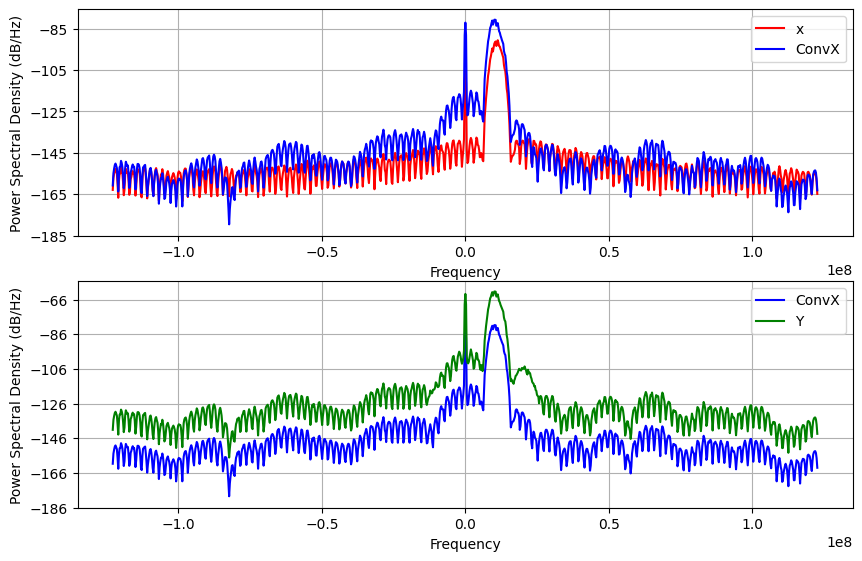

In [311]:
### plot the x and y psd using .psd
import matplotlib.pyplot as plt
### draw with 3 sub plots : 3 comparsions plots, x r, Conv b, PolyX g respectively
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.psd(x, NFFT = 2048, Fs = fs, color = 'r')
plt.psd(ConvX, NFFT = 2048, Fs = fs, color = 'b')
plt.legend(['x', 'ConvX'])

plt.subplot(3, 1, 2)
plt.psd(ConvX, NFFT = 2048, Fs = fs, color = 'b')
plt.psd(PolyX, NFFT = 2048, Fs = fs, color = 'g')
plt.legend(['ConvX', 'Y'])

plt.show()


